训练集大小: 13209
验证集大小: 3303
测试集大小: 4128
RegressionModel(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=30, out_features=1, bias=True)
)
轮次 10/100, 训练损失: 0.3633, 验证损失: 0.4079
轮次 20/100, 训练损失: 0.3365, 验证损失: 0.3958
轮次 30/100, 训练损失: 0.3199, 验证损失: 0.3668
轮次 40/100, 训练损失: 0.3084, 验证损失: 0.3631
轮次 50/100, 训练损失: 0.3004, 验证损失: 0.3449
轮次 60/100, 训练损失: 0.2948, 验证损失: 0.3242
轮次 70/100, 训练损失: 0.2910, 验证损失: 0.3292
轮次 80/100, 训练损失: 0.2909, 验证损失: 0.3200
轮次 90/100, 训练损失: 0.2897, 验证损失: 0.3362
轮次 100/100, 训练损失: 0.2888, 验证损失: 0.3369
训练集 - 均方误差: 0.2873, 平均绝对误差: 0.3742
验证集 - 均方误差: 0.3369, 平均绝对误差: 0.3955
测试集 - 均方误差: 0.3116, 平均绝对误差: 0.3855


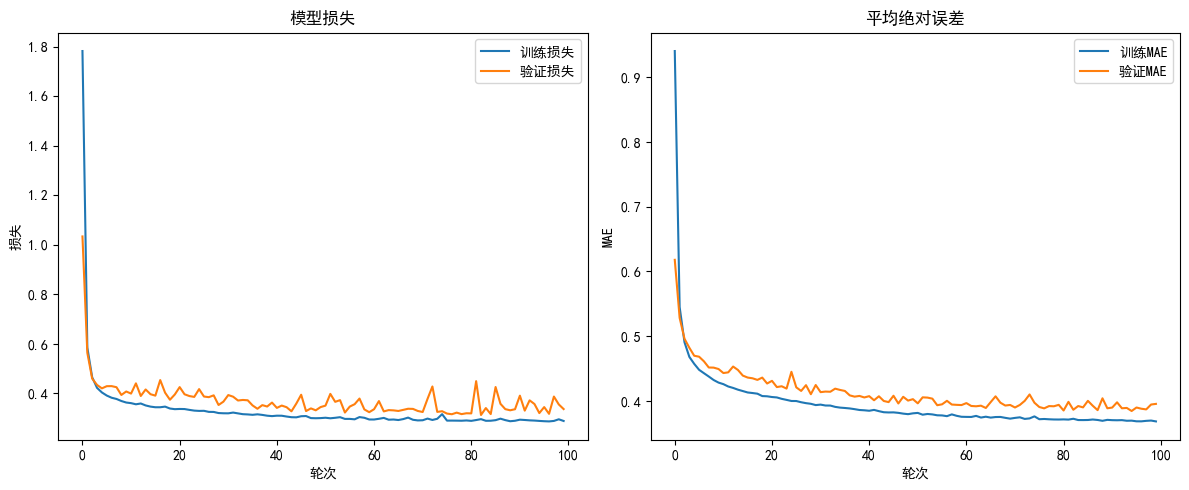

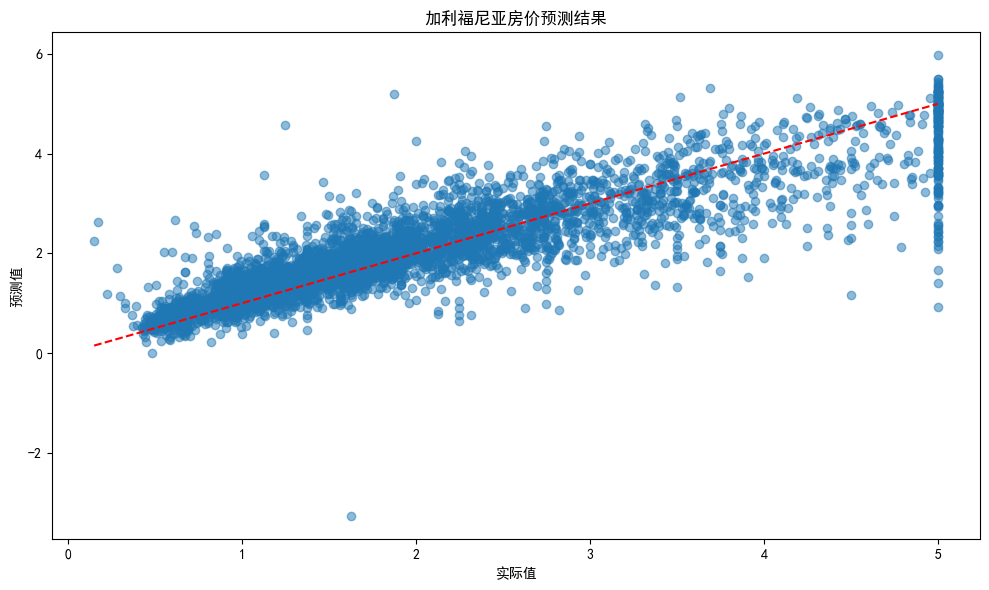

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 转换为PyTorch张量
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30)
        self.activation = nn.ReLU()
        self.output = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.output(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 打印模型结构
print(model)

# 训练模型
epochs = 100
train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(epochs):
    # 训练模式
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_mae += torch.sum(torch.abs(outputs - targets)).item()
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_mae = running_mae / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    train_maes.append(epoch_train_mae)
    
    # 验证模式
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            running_mae += torch.sum(torch.abs(outputs - targets)).item()
    
    epoch_val_loss = running_loss / len(val_loader.dataset)
    epoch_val_mae = running_mae / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_maes.append(epoch_val_mae)
    
    if (epoch + 1) % 10 == 0:
        print(f'轮次 {epoch+1}/{epochs}, 训练损失: {epoch_train_loss:.4f}, 验证损失: {epoch_val_loss:.4f}')

# 评估模型
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
            running_mae += torch.sum(torch.abs(outputs - targets)).item()
    
    return running_loss / len(dataloader.dataset), running_mae / len(dataloader.dataset)

train_loss, train_mae = evaluate(model, train_loader, criterion)
val_loss, val_mae = evaluate(model, val_loader, criterion)
test_loss, test_mae = evaluate(model, test_loader, criterion)

print(f"训练集 - 均方误差: {train_loss:.4f}, 平均绝对误差: {train_mae:.4f}")
print(f"验证集 - 均方误差: {val_loss:.4f}, 平均绝对误差: {val_mae:.4f}")
print(f"测试集 - 均方误差: {test_loss:.4f}, 平均绝对误差: {test_mae:.4f}")

# 绘制学习曲线
plt.figure(figsize=(12, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('模型损失')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()

# MAE曲线
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='训练MAE')
plt.plot(val_maes, label='验证MAE')
plt.title('平均绝对误差')
plt.xlabel('轮次')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 预测结果可视化
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy().flatten()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('加利福尼亚房价预测结果')
plt.tight_layout()
plt.show()